In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from summit.utils.dataset import DataSet
from summit.strategies.random import lhs
from summit.strategies import TSEMO
from summit.benchmarks import DTLZ2

import GPy
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hiplot as hip

Load data from unit test of TSEMO.

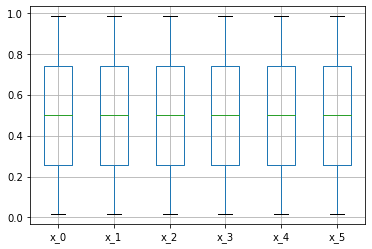

In [10]:
tsemo = TSEMO.load('data/tsemo_settings.json')
data = tsemo.all_experiments
data[data['strategy']=='LHS'].boxplot(column=[f'x_{i}'for i in range(6)])

In [11]:
n_training = 35
input_columns = [v.name for v in tsemo.domain.input_variables]
output_columns = ['y_0', 'y_1']
# Scale decision variables between 0 and 1
# inputs = data[data['strategy']=='LHS'][input_columns]
inputs = data[input_columns].iloc[0:n_training]
input_min = inputs.min()
input_max = inputs.max()
scaled_inputs = (inputs-input_min)/(input_max-input_min)

# Scale objectives to 0 mean and unit variance
# outputs = data[data['strategy']=='LHS'][output_columns]
outputs = data[output_columns][0:n_training]
output_mean = outputs.mean()
output_std = outputs.std()
scaled_outputs = (outputs-output_mean)/output_std

# Join back
scaled_data = pd.concat([scaled_inputs, scaled_outputs], axis=1)
scaled_data.head(5)

,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0.379310,0.517241,0.724138,0.551724,0.206897,0.344828,0.341530,-0.686758
1,0.310345,1.000000,0.448276,0.655172,0.965517,0.655172,1.032255,-0.564391
2,0.655172,0.931034,0.586207,0.758621,0.655172,0.793103,-0.139632,0.411246
3,0.586207,0.172414,0.137931,0.137931,0.724138,0.068966,0.348190,0.621530
4,0.275862,0.896552,0.482759,0.241379,0.689655,0.000000,1.089316,-0.724359


## Hyperparameter Screening

In [12]:
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                            scaled_outputs[['y_0']].to_numpy(), 
                            kern, noise_var=1e-3)
m.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m

GP_regression.,value,constraints,priors
Exponential.variance,1.0,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.5012393760883331,"0.0024787521766663585,1.0",


In [13]:
# Try changing kernel lengthscales
m.kern.lengthscale = 2*np.ones(6)
print("Lengthscales=2:", m.objective_function())

m.kern.lengthscale = 0.2*np.ones(6)
print("Lengthscales=0.2:", m.objective_function())

Lengthscales=2: 68.97574779172123
Lengthscales=0.2: 73.28253754120928


* Parameters to screen:
    * Variance
    * Lengthscales (x6)
    * Gaussian noise


In [ ]:
screening_values = lhs(8, int(1e5))
scaling_variance_log=[np.log(np.sqrt(1e-3)), np.log(np.sqrt(1e3))]
scaling_lengthscales_log=[np.log(np.sqrt(1e-3)), np.log(np.sqrt(1e3))]
scaling_noise_log=[-6, 0]

records = []

for values in screening_values:
    variance = values[0]*(scaling_variance_log[1]-scaling_variance_log[0])+scaling_variance_log[0]
    lengthscales = values[1:7]*(scaling_lengthscales_log[1]-scaling_lengthscales_log[0])+scaling_lengthscales_log[0]
    noise = values[7]*(scaling_noise_log[1]-scaling_noise_log[0])+scaling_noise_log[0]
    m.kern.variance = np.exp(variance)
    m.kern.lengthscale  = np.exp(lengthscales)
    m.Gaussian_noise.variance = np.exp(noise)
    record = {f'log_x_{i}': lengthscale for i, lengthscale in enumerate(lengthscales)}
    record.update({'log_variance': variance,'log_noise': noise,
                   'objective_function': m.objective_function()})
    records.append(record)
    
df = pd.DataFrame(records)

In [ ]:
# records_top = df[df['objective_function']<40].to_dict(orient='records')
exp = hip.Experiment.from_iterable(records)
exp.display_data(hip.Displays.PARALLEL_PLOT).update({'hide': ['uid']})
exp.display()

This shows us that the hyperparameter optimisation landscape is rough with lots of local minima. We need a global optimisation algorithm to solve it.

##  Optimizer

In [7]:
#First the L-BFSG optimizer
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m_bfsg = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                                   scaled_outputs[['y_0']].to_numpy(), 
                                   kern, noise_var=1e-3)
m_bfsg.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m_bfsg.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m_bfsg.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m_bfsg.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m_bfsg.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m_bfsg.optimize_restarts(10)
m_bfsg

Optimization restart 1/10, f = 41.31192366273964
Optimization restart 2/10, f = 72.1237264604961
Optimization restart 3/10, f = 103.21176215736315
Optimization restart 4/10, f = 153.88056363337233


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/core/parameterization/priors.py:182: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/10, f = 63.986583996090744
Optimization restart 6/10, f = 99.73095545776857
Optimization restart 7/10, f = 98.46363915290166


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 8/10, f = 49.37324854371545
Optimization restart 9/10, f = 75.50417918125636
Optimization restart 10/10, f = 61.5406457374283


GP_regression.,value,constraints,priors
Exponential.variance,0.34905044130100016,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.00247875570202701,"0.0024787521766663585,1.0",


In [104]:
m_bfsg.kern.lengthscale

index,GP_regression.Exponential.lengthscale,constraints,priors
[0],0.43636608,+ve,"lnN(0, 10)"
[1],5.20891214,+ve,"lnN(0, 10)"
[2],5.00195590,+ve,"lnN(0, 10)"
[3],2.92273922,+ve,"lnN(0, 10)"
[4],5.48942342,+ve,"lnN(0, 10)"
[5],1.94519248,+ve,"lnN(0, 10)"


In [102]:
test_data = data.iloc[n_training:]
scaled_test = (test_data[input_columns]-input_min)/(input_max-input_min)
y_pred_scaled, y_pred_var_scaled = m_bfsg.predict(scaled_test.to_numpy())

y_pred = y_pred_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var = y_pred_var_scaled*output_std['y_0'].to_numpy()[0]
y_real = test_data['y_0'].to_numpy()
square_error = (y_pred-y_real)**2
rmse = np.sqrt(np.mean(square_error))
print("Number of training data:", data.shape[0]-n_training)
print("Root mean square error:",rmse)

Number of training data: 94
Root mean square error: 0.07693644332036981


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Parity Plot')

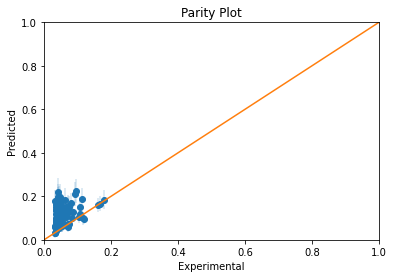

In [110]:
plt.scatter(y_real, y_pred)
plt.errorbar(y_real, y_pred, yerr=y_pred_var, fmt='none', alpha=0.2)
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Parity Plot')

In [106]:
class BasinHopping(GPy.inference.optimization.Optimizer):
    
    def __init__(self, T=1.0, **kwargs):
        super().__init__(**kwargs)
        self.opt_name = 'BasinHopping'
        self.T = T
        
    def opt(self, x_init, f_fp=None, f=None, fp=None):
        minimizer_kwargs = {"jac": True}
        res = scipy.optimize.basinhopping(f_fp, x_init, niter=self.max_iters, 
                                          minimizer_kwargs=minimizer_kwargs,
                                          T=self.T)
        self.f_opt = res.fun
        self.x_opt = res.x
        self.status = 'maximum number of function evaluations exceeded'

In [107]:
#Optimize using basin hopping
kern = GPy.kern.Exponential(input_dim=6,ARD=True)
m = GPy.models.GPRegression(scaled_inputs.to_numpy(), 
                            scaled_outputs[['y_0']].to_numpy(),
                            kern, 
                            noise_var=1e-3)
m.kern.lengthscale.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3),warning=False)
m.kern.lengthscale.set_prior(GPy.priors.LogGaussian(0, 10), warning=False)
m.kern.variance.constrain_bounded(np.sqrt(1e-3), np.sqrt(1e3), warning=False)
m.kern.variance.set_prior(GPy.priors.LogGaussian(-6, 10), warning=False)
m.Gaussian_noise.constrain_bounded(np.exp(-6), 1, warning=False)
m.optimize(optimizer=BasinHopping(max_iters=100, T=0.1))
m

GP_regression.,value,constraints,priors
Exponential.variance,0.3490391822532001,+ve,"lnN(-6, 10)"
Exponential.lengthscale,"(6,)",+ve,"lnN(0, 10)"
Gaussian_noise.variance,0.002478752181011732,"0.0024787521766663585,1.0",


In [108]:
test_data = data.iloc[n_training:]
scaled_test = (test_data[input_columns]-input_min)/(input_max-input_min)
y_pred_scaled, y_pred_var_scaled = m.predict(scaled_test.to_numpy())

y_pred = y_pred_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var = y_pred_var_scaled*output_std['y_0'].to_numpy()[0]
y_real = test_data['y_0'].to_numpy()
square_error = (y_pred-y_real)**2
rmse = np.sqrt(np.mean(square_error))
print("Number of training data:", n_training)
print("Number of test data:", data.shape[0]-n_training)
print("Root mean square error:",rmse)

Number of training data: 35
Number of test data: 94
Root mean square error: 0.07693634072131462


 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


Text(0.5, 1.0, 'Parity Plot')

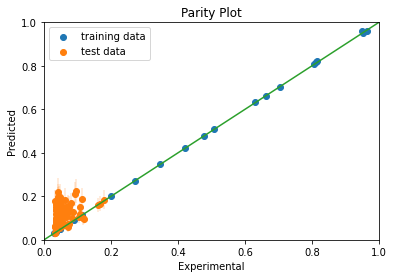

In [109]:
y_pred_train_scaled , y_pred_var_train_scaled = m.predict(scaled_inputs.to_numpy())
y_pred_train = y_pred_train_scaled[:,0]*output_std['y_0'].to_numpy()[0] + output_mean['y_0'].to_numpy()[0]
y_pred_var_train = y_pred_var_train_scaled*output_std['y_0'].to_numpy()[0]
plt.scatter(outputs['y_0'].to_numpy(), y_pred_train, label="training data")
plt.errorbar(outputs['y_0'].to_numpy(), y_pred_train, 
             yerr=y_pred_var_train, fmt='none', alpha=0.2)
plt.scatter(y_real, y_pred, label='test data')
plt.errorbar(y_real, y_pred, yerr=y_pred_var, fmt='none', alpha=0.2)
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.xlabel('Experimental')
plt.ylabel('Predicted')
plt.title('Parity Plot')

Because all teh training data is centered in one place, it is not able to train a good model.

In [112]:
m.predict(0.5*np.ones([1,6]))

(array([[0.19653369]]), array([[0.04380293]]))

In [115]:
dtlz2 = DTLZ2()
conditions = DataSet(0.5*np.ones([1,6]), columns=[f'x_{i}' for i in range(6)])
dtlz2.run_experiments(conditions)

,computation_t,experiment_t,strategy,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1
0,0,0.0193219,NaN,0.5,0.5,0.5,0.5,0.5,0.5,0.707107,0.707107


In [ ]:
plt.